<a href="https://colab.research.google.com/github/tsubauaaa/AITrialTraining/blob/main/Training10/AITraining10-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# データセットの説明

https://www.kaggle.com/uwrfkaggler/ravdess-emotional-speech-audio

```
Filename identifiers
Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
Vocal channel (01 = speech, 02 = song).
Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
Repetition (01 = 1st repetition, 02 = 2nd repetition).
Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).
```

# 課題2
1. wav2vecを内包する新たなモデルを作成  
last_hidden_stateをtransformer or LSTMにいれる
2. 学習


In [ ]:
!pip install transformers

In [ ]:
 # Google Driveをマウントする
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 各音声ファイルのリストを取得

from pathlib import Path

audio_dir = Path('/content/drive/My Drive/Colab Notebooks/AITraining/RAVDESS/')
audio_files = audio_dir.glob("**/*.wav")
audio_file_list = list(audio_files)
print(audio_file_list)
print(len(audio_file_list))

[PosixPath('/content/drive/My Drive/Colab Notebooks/AITraining/RAVDESS/Actor_10/03-01-02-02-02-01-10.wav'), PosixPath('/content/drive/My Drive/Colab Notebooks/AITraining/RAVDESS/Actor_10/03-01-04-01-02-01-10.wav'), PosixPath('/content/drive/My Drive/Colab Notebooks/AITraining/RAVDESS/Actor_10/03-01-04-01-01-01-10.wav'), PosixPath('/content/drive/My Drive/Colab Notebooks/AITraining/RAVDESS/Actor_10/03-01-04-02-02-01-10.wav'), PosixPath('/content/drive/My Drive/Colab Notebooks/AITraining/RAVDESS/Actor_10/03-01-01-01-01-02-10.wav'), PosixPath('/content/drive/My Drive/Colab Notebooks/AITraining/RAVDESS/Actor_10/03-01-03-02-01-01-10.wav'), PosixPath('/content/drive/My Drive/Colab Notebooks/AITraining/RAVDESS/Actor_10/03-01-02-02-01-01-10.wav'), PosixPath('/content/drive/My Drive/Colab Notebooks/AITraining/RAVDESS/Actor_10/03-01-01-01-02-02-10.wav'), PosixPath('/content/drive/My Drive/Colab Notebooks/AITraining/RAVDESS/Actor_10/03-01-03-01-01-01-10.wav'), PosixPath('/content/drive/My Drive/C

In [ ]:
# モデル定義
from transformers import Wav2Vec2Processor, Wav2Vec2Model
import torch.nn.functional as F
import torch.nn as nn
import torch

class Wav2VecClassifier(nn.Module):
    def __init__(self, hidden_size=128, num_classes=8, device='cpu', sr=16000):
        super(Wav2VecClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.sr = sr
        self.device = device
        self.processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
        self.model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")
        self.lstm = nn.LSTM(768, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, h, c):
        input_values = self.processor(x, return_tensors="pt", sampling_rate=self.sr).input_values
        # (batch_size, seq_len)に次元入れ替え(batch first対応)
        input_values = torch.squeeze(input_values.permute(1, 2, 0)).to(self.device)
        hidden_states = self.model(input_values).last_hidden_state
        lstm_out, (h, c) = self.lstm(hidden_states, (h, c))
        # lstm_hidden(h)をhidden_sizeに平す
        out = self.fc(h.view(-1, self.hidden_size))
        out = self.softmax(out)
        return out

    def init_hidden(self, batch_size):
        h = torch.zeros(1, batch_size, self.hidden_size)
        c = torch.zeros(1, batch_size, self.hidden_size)
        return h, c

In [ ]:
import librosa
import numpy as np
import gc

# 生データのデータセットクラス
class AudioRawDataset(torch.utils.data.Dataset):
    def __init__(self, audio_file_list, transform = None, num_classes=8, sr=16000):
        self.transform = transform
        self.file_path_list = audio_file_list
        self.label = [int(x.name.split('-')[2]) - 1 for x in audio_file_list]
        self.sr = sr
        self.datanum = len(self.label)

    def __len__(self):
        return self.datanum

    def __getitem__(self, idx):
        audio_file_path = self.file_path_list[idx]
        out_label = self.label[idx]
        out_data, _ = librosa.load(audio_file_path, sr=self.sr)

        if self.transform:
            out_data = self.transform(out_data)

        return out_data, out_label

In [ ]:
# (最大シーケンス長×バッチサイズ×特徴量次元数)のTensorを適当にゼロ埋めして返す
class PadCollate:
    """
    a variant of callate_fn that pads according to the longest sequence in
    a batch of sequences
    """

    def __init__(self, dim=1):
        """
        args:
            dim - the dimension to be padded (dimension of time in sequences)
        """
        self.dim = dim

    def pad_collate(self, batch):
        '''
        Padds batch of variable length

        note: it converts things ToTensor manually here since the ToTensor transform
        assume it takes in images rather than arbitrary tensors.
        '''
        ## get sequence lengths
        lengths = torch.tensor([len(data) for data, target in batch])
        ## padd
        batch_data = [torch.Tensor(data) for data, target in batch]
        batch_data = torch.nn.utils.rnn.pad_sequence(batch_data, batch_first=True)
        target = torch.tensor([target for data, target in batch], dtype=torch.int64)
        return batch_data, target

    def __call__(self, batch):
        return self.pad_collate(batch)


In [ ]:
# tuple(data, target)
audio_dataset = AudioRawDataset(audio_file_list)
n_samples = len(audio_dataset)
train_size = int(len(audio_dataset) * 0.8)
val_size = n_samples - train_size
train_dataset, val_dataset = torch.utils.data.random_split(audio_dataset, [train_size, val_size])

In [ ]:
print(f'data: {train_dataset[1][0]}, data shape: {train_dataset[1][0].shape}') # data
print(train_dataset[1][1]) # target type=int

data: [ 3.6928776e-09 -5.5345888e-09  7.7532745e-09 ... -1.4660800e-05
 -2.2482664e-05  0.0000000e+00], data shape: (61395,)
1


In [ ]:
# Tensor
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True, collate_fn=PadCollate())
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, drop_last=True, collate_fn=PadCollate())

In [ ]:
# # イテレータ化
# train_dataiter = iter(train_loader)
# # データ取得
# data, target = train_dataiter.next()
# print(data.shape, target.shape) # data: (batch_size, seq_len), target: (batch_size)
# print(data.dtype, target.dtype) # data: (batch_size, seq_len), target: (batch_size)
# print(data, target) # data: (batch_size, seq_len), target: (batch_size)
# print(data[0][30000:])
# print(data[0].sum())

In [ ]:
import torch.optim as optim
from tqdm.notebook import tqdm
import librosa
import os
import time
import datetime

print(f"start training {datetime.datetime.now()}")

# device = torch.device('cuda')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'device: {device}')
model = Wav2VecClassifier(device=device)
model.to(device)
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

n_epochs = 80
losses = []
for epoch in tqdm(range(n_epochs)):
    t0 = time.time()
    total_loss = 0
    total_size = 0
    model.train()
    for batch_id, (data, target) in enumerate(train_loader):
        # data, target = data.transpose(1, 0), target.to(device)
        data, target = data, target.to(device)
        optimizer.zero_grad()
        h, c = model.init_hidden(data.size(0))
        h, c = h.to(device), c.to(device)
        output = model(data, h, c)
        # print(f'output: {output}, target: {target}')
        loss = criterion(output, target)
        total_loss += loss.item()
        total_size += data.size(0)
        loss.backward()
        optimizer.step()
    losses.append(total_loss/(batch_id+1))
    print("epoch", epoch, "\t", "loss", total_loss/(batch_id+1), "elapsed time", time.time() - t0 )
print(f"done {datetime.datetime.now()}")

start training 2021-04-04 04:10:52.903540
device: cuda:0


Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 0 	 loss 2.0751473440064325 elapsed time 457.945597410202
epoch 1 	 loss 2.0723826355404324 elapsed time 198.85115957260132
epoch 2 	 loss 2.0667464203304715 elapsed time 198.93284225463867
epoch 3 	 loss 2.0638683835665383 elapsed time 199.43501353263855
epoch 4 	 loss 2.058647851149241 elapsed time 199.35673999786377
epoch 5 	 loss 2.0535363819864063 elapsed time 200.20089554786682
epoch 6 	 loss 2.0485225319862366 elapsed time 199.76551580429077
epoch 7 	 loss 2.0392518209086523 elapsed time 199.03801155090332
epoch 8 	 loss 2.0634017984072366 elapsed time 200.19202494621277
epoch 9 	 loss 2.0551303095287747 elapsed time 199.1893916130066
epoch 10 	 loss 2.029232339726554 elapsed time 199.9474699497223
epoch 11 	 loss 2.0388021071751914 elapsed time 201.32052779197693
epoch 12 	 loss 2.022564238972134 elapsed time 200.27189016342163
epoch 13 	 loss 2.0093773769007788 elapsed time 199.9253318309784
epoch 14 	 loss 1.9872970183690388 elapsed time 199.64849829673767
epoch 15 	 lo

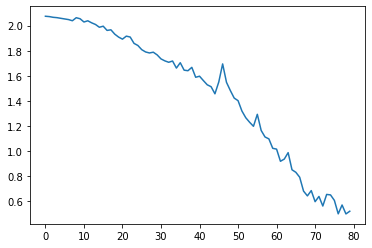

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(losses)

In [ ]:
from sklearn.metrics import classification_report
pred = []
Y = []
for data, target in val_loader:
    with torch.no_grad():
        data, target = data, target.to(device)
        h, c = model.init_hidden(data.size(0))
        h, c = h.to(device), c.to(device)
        output = model(data, h, c)
    pred += [int(l.argmax()) for l in output]
    Y += [int(l) for l in target]

print(classification_report(Y, pred))

              precision    recall  f1-score   support

           0       0.25      0.39      0.30        18
           1       1.00      0.33      0.50        36
           2       0.38      0.56      0.46        41
           3       0.71      0.46      0.56        37
           4       0.64      0.89      0.75        38
           5       0.67      0.60      0.63        43
           6       0.90      0.70      0.79        37
           7       0.77      0.87      0.81        38

    accuracy                           0.62       288
   macro avg       0.66      0.60      0.60       288
weighted avg       0.69      0.62      0.62       288

